# Univariate Multistep CNN Example

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

In [1]:
import pandas as pd
import numpy as np

from numpy import array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

Separate a multivariate sequence into samples

In [2]:
def split_sequence(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # Find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are bound by sequence
        if out_end_ix > len(sequences) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return array(X), array(y)

Load the data

In [3]:
df = pd.read_csv("SP500.csv")

Show the data

In [4]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [5]:
start_date = df.Date.min()
end_date = df.Date.max()

In [6]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [7]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [8]:
df = df.interpolate(method='linear', limit_direction='both')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,7.755000e+05,0.0,0.0
1,2000-05-20,95.642869,95.642869,93.713029,94.583211,1.133867e+06,0.0,0.0
2,2000-05-21,95.179710,95.179710,92.941096,94.386721,1.492233e+06,0.0,0.0
3,2000-05-22,94.716551,94.716551,92.169162,94.190231,1.850600e+06,0.0,0.0
4,2000-05-23,94.463952,94.463952,92.758675,92.758675,3.739000e+05,0.0,0.0
...,...,...,...,...,...,...,...,...
7784,2021-09-10,453.059998,453.510010,447.299988,447.540009,3.023500e+06,0.0,0.0
7785,2021-09-11,452.266663,452.650004,446.896657,447.886668,3.018133e+06,0.0,0.0
7786,2021-09-12,451.473328,451.789998,446.493327,448.233327,3.012767e+06,0.0,0.0
7787,2021-09-13,450.679993,450.929993,446.089996,448.579987,3.007400e+06,0.0,0.0


Define input sequence

In [9]:
raw_seq = np.array(df.Close)

 Choose a number of time steps

In [10]:
n_steps_in = 10
n_steps_out = 3

Convert into input/output

In [11]:
X, y = split_sequence(raw_seq[:-2*n_steps_in-2*n_steps_out], n_steps_in, n_steps_out)

Reshape from [samples, timesteps] into [samples, timesteps, features]

In [12]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

Set test data

In [13]:
X_test, y_test = split_sequence(raw_seq[-2*n_steps_in-2*n_steps_out:], n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

Define model

In [14]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))

In [15]:
model.compile(optimizer='adam', loss='mse')

Fit model

In [16]:
model.fit(X, y, epochs=200)

Epoch 1/200
243/243 [==============================] - 0s 800us/step - loss: 1050.6152
Epoch 2/200
243/243 [==============================] - 0s 751us/step - loss: 12.7293
Epoch 3/200
243/243 [==============================] - 0s 706us/step - loss: 12.7673
Epoch 4/200
243/243 [==============================] - 0s 691us/step - loss: 12.7107
Epoch 5/200
243/243 [==============================] - 0s 677us/step - loss: 13.1957
Epoch 6/200
243/243 [==============================] - 0s 694us/step - loss: 13.1583
Epoch 7/200
243/243 [==============================] - 0s 735us/step - loss: 12.8379
Epoch 8/200
243/243 [==============================] - 0s 691us/step - loss: 13.3806
Epoch 9/200
243/243 [==============================] - 0s 720us/step - loss: 12.6895
Epoch 10/200
243/243 [==============================] - 0s 966us/step - loss: 12.5881
Epoch 11/200
243/243 [==============================] - 0s 682us/step - loss: 12.4273
Epoch 12/200
243/243 [==============================] - 0s 70

243/243 [==============================] - 0s 696us/step - loss: 7.4992
Epoch 98/200
243/243 [==============================] - 0s 699us/step - loss: 8.3194
Epoch 99/200
243/243 [==============================] - 0s 696us/step - loss: 8.1450
Epoch 100/200
243/243 [==============================] - 0s 688us/step - loss: 8.1123
Epoch 101/200
243/243 [==============================] - 0s 693us/step - loss: 8.3144
Epoch 102/200
243/243 [==============================] - 0s 725us/step - loss: 7.9080
Epoch 103/200
243/243 [==============================] - 0s 720us/step - loss: 7.6136
Epoch 104/200
243/243 [==============================] - 0s 805us/step - loss: 8.0697
Epoch 105/200
243/243 [==============================] - 0s 816us/step - loss: 7.8922
Epoch 106/200
243/243 [==============================] - 0s 688us/step - loss: 7.9692
Epoch 107/200
243/243 [==============================] - 0s 737us/step - loss: 8.0137
Epoch 108/200
243/243 [==============================] - 0s 723us/step

Demonstrate training

In [17]:
yhat = model.predict(X)

In [18]:
import matplotlib.pyplot as plt

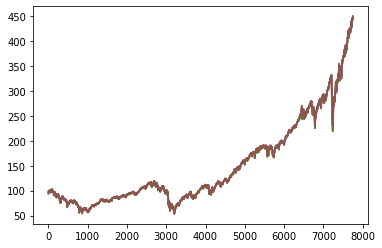

In [19]:
plt.plot(y)
plt.plot(yhat)
plt.show()

Demonstrate prediction

In [20]:
yhat = model.predict(X_test)

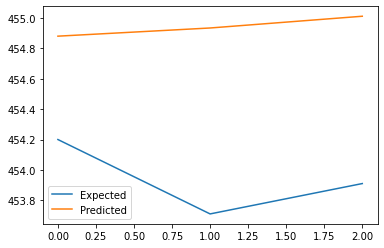

In [21]:
plt.plot(y_test[0], label='Expected')
plt.plot(yhat[0], label='Predicted')
plt.legend()
plt.show()

In [22]:
print(f"Predicted: {yhat[0][0]:.2f}  Expected: {y_test[0][0]:.2f}")

Predicted: 454.88  Expected: 454.20


**THIS IS NOT AN INVESTMENT ADVICE!**